In [1]:
%load_ext autoreload
%autoreload

In [2]:
import matplotlib.pyplot as plt

In [3]:
import argparse
import torch
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
import os,random
import os.path as osp
import sys
import time
from utils import *

from mace.mace_gnn import MBPGNN

/n/fs/vl/rb4785/miniforge3/envs/mace_ng/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
from NeuroGraph.datasets import NeuroGraphDataset

In [177]:
root = "/n/fs/scratch/rb4785/NeuroGraph_data/"
dataset = NeuroGraphDataset(root=root, name="HCPAge")

Processing...
Done!


In [66]:
d = dataset[0]

In [68]:
d.vectors

tensor([0.])

In [31]:
torch.zeros((1))

tensor([0.])

In [69]:
l = torch.nn.Linear(8, 16)

In [94]:
d.x.to('cpu')

tensor([[ 0.0000,  0.5451,  0.5538,  ...,  0.1681,  0.0870,  0.1291],
        [ 0.5451,  0.0000,  0.6339,  ...,  0.0127, -0.0067,  0.0350],
        [ 0.5538,  0.6339,  0.0000,  ...,  0.1448,  0.1179,  0.1731],
        ...,
        [ 0.1681,  0.0127,  0.1448,  ...,  0.0000,  0.3854,  0.3324],
        [ 0.0870, -0.0067,  0.1179,  ...,  0.3854,  0.0000,  0.6345],
        [ 0.1291,  0.0350,  0.1731,  ...,  0.3324,  0.6345,  0.0000]])

In [87]:
l(x).tanh()

tensor([[ 0.6720,  0.7679,  0.6730,  0.5543,  0.2376,  0.3331,  0.1627, -0.6665,
         -0.3972,  0.2057,  0.9348, -0.6944,  0.1965, -0.3750,  0.1426,  0.7873]],
       grad_fn=<TanhBackward0>)

In [95]:
from e3nn import o3

In [141]:
ir = o3.Irreps("1x0e")
ir.num_irreps

1

In [178]:
[d.x.shape for d in dataset]

[torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 

In [135]:
i = o3.Irreps([(16, (0,1))])
o3.Irrep(0, 1).count(1)

NotImplementedError: 

In [159]:
y = torch.randn((7,3))

In [179]:
[x for x in [tuple(d.x.shape) for d in dataset] if x != (1000, 1000)]

[]

In [199]:
ir = o3.Irreps("256x0e + 256x1o")
ir

256x0e+256x1o

In [204]:
dataset[0].num_nodes

1000

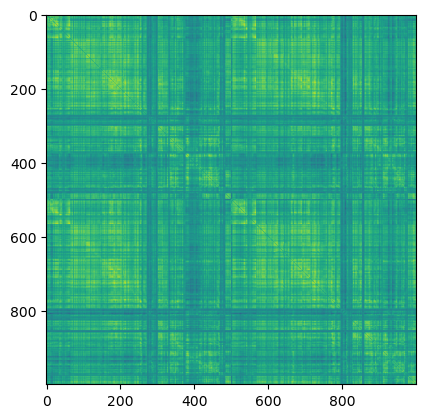

In [194]:
plt.imshow(dataset[0].x)

In [172]:
d = dataset[-1]


In [173]:
d

Data(x=[1000, 1000], edge_index=[2, 45780], y=[1], edge_attr=[1], vectors=[1])

In [114]:
irreps = "2x0e"
if irreps.strip() != "":
  for mul_ir in irreps.split('+'):
      if 'x' in mul_ir:
          mul, ir = mul_ir.split('x')
          print(mul, ir)
          print("mul = int(mul)")
          print("ir = Irrep(ir)")
      else:
          mul = 1
          print("ir = Irrep(mul_ir)")

      # assert isinstance(mul, int) and mul >= 0
      # out.append(_MulIr(mul, ir))

2 0e
mul = int(mul)
ir = Irrep(ir)


# Spherical Harmonics

In [27]:
import e3nn
from e3nn import o3

In [67]:
sh_irreps = o3.Irreps.spherical_harmonics(0) # spherical harmonics irreps
# up to l=3
print(sh_irreps, sh_irreps.dim)

1x0e 1


In [68]:
sh = o3.SphericalHarmonics(
  sh_irreps, normalize=True, normalization='component'
)

In [71]:
sh(torch.Tensor([[2,0,0], [0,0,1]]))

tensor([[1.],
        [1.]])

In [72]:
import pandas as pd

In [91]:
df = pd.read_csv("results/results_new.csv")
df

,label,dataset,model,epochs,best_val_acc,best_val_loss,test_acc,test_loss
0,novecs,HCPAge,MBPGNN,10,0.514019,0.0,0.403756,0.278502
1,novecs,HCPAge,GCNConv,10,0.467290,0.0,0.441315,0.278897
2,novecs,HCPAge,GraphConv,10,0.411215,0.0,0.460094,0.275382
3,novecs,HCPTask,MBPGNN,10,0.728859,0.0,0.713230,0.456199
4,novecs,HCPTask,GCNConv,10,0.602685,0.0,0.581598,0.445058
5,novecs,HCPTask,GraphConv,10,0.600000,0.0,0.613835,0.438387
6,novecs,HCPAge,MBPGNN,100,0.514019,0.0,0.422535,0.265355
7,novecs,HCPAge,GCNConv,100,0.514019,0.0,0.450704,0.259396
8,novecs,HCPAge,GraphConv,100,0.495327,0.0,0.455399,0.280556
9,novecs,HCPTask,MBPGNN,100,0.965101,0.0,0.958361,0.304897


In [92]:
df[df.epochs == 100].groupby(['dataset', 'model']).aggregate('mean', 'label').sort_values('test_acc', ascending=False)

epochs  best_val_acc  best_val_loss  test_acc  test_loss
dataset model                                                                
HCPTask MBPGNN        100.0      0.965101            0.0  0.958361   0.304897
        GeneralConv   100.0      0.951678            0.0  0.942915   0.313552
        GCNConv       100.0      0.936913            0.0  0.925453   0.316722
        GraphConv     100.0      0.932886            0.0  0.917394   0.307715
HCPAge  GraphConv     100.0      0.495327            0.0  0.455399   0.280556
        GCNConv       100.0      0.514019            0.0  0.450704   0.259396
        GeneralConv   100.0      0.457944            0.0  0.431925   0.273598
        MBPGNN        100.0      0.514019            0.0  0.422535   0.265355

In [95]:
torch.nn.functional.normalize(torch.randn((3, 5)), dim=0)

tensor([[-0.3093,  0.1686,  0.0448,  0.1119,  0.2820],
        [-0.7851,  0.9710, -0.9990,  0.1096,  0.2485],
        [ 0.5367, -0.1694,  0.0060,  0.9877,  0.9267]])